In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../../figure_style.mplstyle')

import sys
sys.path.insert(0, '../src')

import logging
logging.basicConfig(level=logging.INFO)

Darcy flow refers to the motion of a fluid through a Hele-Shaw cell. The steady-state Darcy flow equation examined in the FNO paper is equivalent to a forced diffusion equation for a 2D field $u(x, y)$ with inhomogeneous diffision coefficient

$$ -\nabla \cdot \left[ D(x, y) \nabla u(x, y) \right] = f(x, y) $$

In the dataset presented for the FNO paper, they fix $f(x) = 1$ and consider random diffusion coefficient fields $D(x, y)$. The objective is to find an operator mapping $D(x, y) \rightarrow u(x, y)$

INFO:data_processing:Loading train_dataset from ../data/Darcy/piececonst_r421_N1024_smooth1.mat


INFO:data_processing:Input shape: (1024, 211, 211)	Output shape: (1024, 211, 211)
INFO:data_processing:Adding positional encoding
INFO:data_processing:Creating TensorDataset with input shape: torch.Size([1024, 3, 211, 211]), output shape: torch.Size([1024, 1, 211, 211])
INFO:data_processing:Loading val dataset from ../data/Darcy/piececonst_r421_N1024_smooth2.mat
INFO:data_processing:Input shape: (1024, 211, 211)	Output shape: (1024, 211, 211)
INFO:data_processing:Adding positional encoding
INFO:data_processing:Creating TensorDataset with input shape: torch.Size([1024, 3, 211, 211]), output shape: torch.Size([1024, 1, 211, 211])
INFO:data_processing:Training dataset length: 1024
INFO:data_processing:Validation dataset length: 1024


[Text(0.5, 0, '$x$'), Text(0.5, 1.0, 'Positional Embedding')]

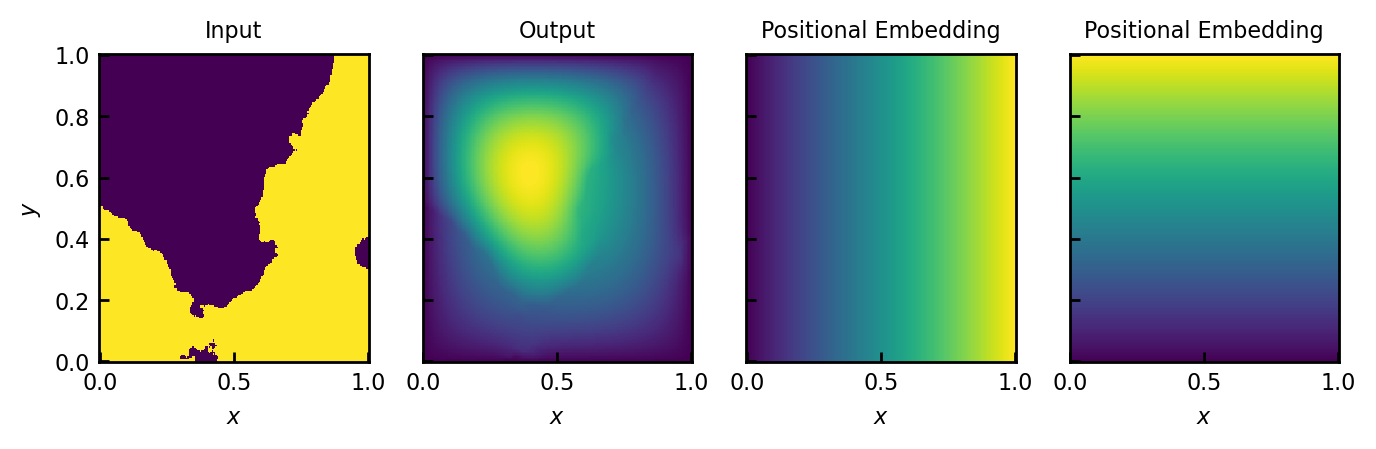

In [16]:
from data_processing import load_darcy_2d_data
train, val = load_darcy_2d_data(space_resolution=2)

fig, ax = plt.subplots(1, 4, figsize=(8, 2), sharex=True, sharey=True)

x, y = train[100]

ax[0].pcolormesh(x[1], x[2], x[0])
ax[1].pcolormesh(x[1], x[2], y[0])
ax[2].pcolormesh(x[1], x[2], x[1])
ax[3].pcolormesh(x[1], x[2], x[2])

ax[0].set(xlabel='$x$', ylabel='$y$', title='Input')
ax[1].set(xlabel='$x$', title='Output')
ax[2].set(xlabel='$x$', title='Positional Embedding')
ax[3].set(xlabel='$x$', title='Positional Embedding')

INFO:train_FNO:Building a FNO2d
INFO:train_FNO:Loading model weights from ../models/Darcy_2d//model_weight.ckpt
INFO:train_FNO:Model reached loss=6.43e-07 at epoch 477


MSE Loss of prediction: 2.43e-07


[Text(0.5, 0, '$x$'), Text(0.5, 1.0, 'Error')]

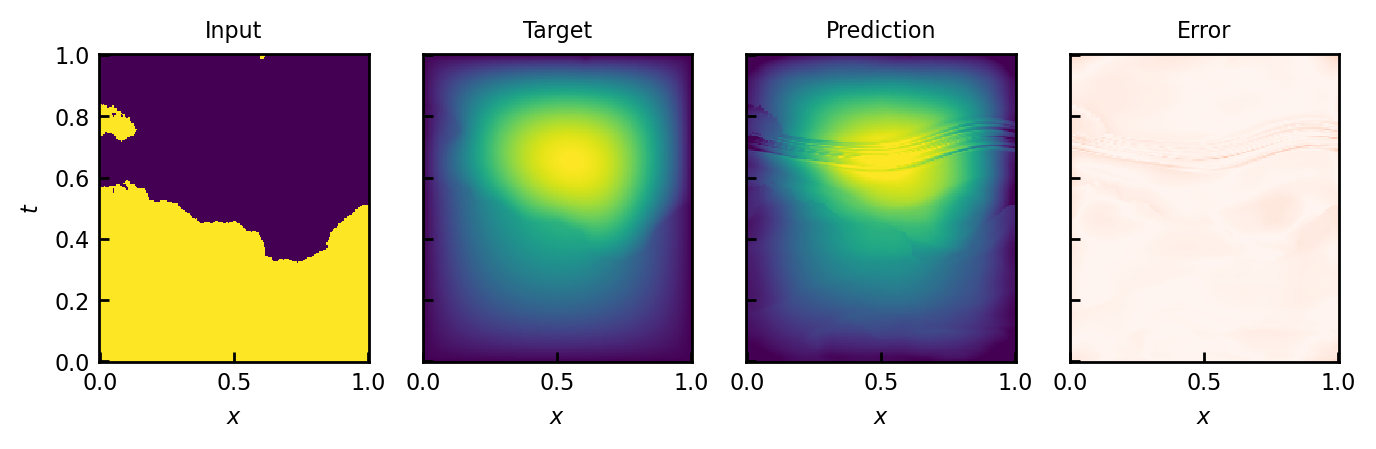

In [34]:
from train_FNO import get_model, get_dataset
import yaml
from pprint import pprint

import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

with open('../models/Darcy_2d/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

model = get_model(config['model'])
#train, val = get_dataset(config['dataset'])
model.eval()
model.to(device);

with torch.no_grad():
    x, y0 = val[10]
    x = x.to(device)

    y1 = model(x[None, :model.in_channels])[0]

    x = x.cpu().numpy()
    y1 = y1.cpu().numpy()
    y0 = y0.cpu().numpy()

fig, ax = plt.subplots(1, 4, figsize=(8, 2), sharex=True, sharey=True)

print(f'MSE Loss of prediction: {np.mean(np.power(y1 - y0, 2)):.3g}')

vmin, vmax = np.min(y0[0]), np.max(y0[0])
ax[0].pcolormesh(x[1], x[2], x[0])
ax[1].pcolormesh(x[1], x[2], y0[0], vmin=vmin, vmax=vmax)
ax[2].pcolormesh(x[1], x[2], y1[0], vmin=vmin, vmax=vmax)
ax[3].pcolormesh(x[1], x[2], np.abs(y1[0] - y0[0]), cmap='Reds', vmin=0, vmax=vmax-vmin)

ax[0].set(xlabel='$x$', ylabel='$t$', title='Input')
ax[1].set(xlabel='$x$', title='Target')
ax[2].set(xlabel='$x$', title='Prediction')
ax[3].set(xlabel='$x$', title='Error')